In [1]:
from lib.all import all_in_one
from lib.show import compare_repartition, histo_continuous, show_hyperparam_opti
from lib.train import iterate_params, choose_params, nb_possibility
from lib.prepare_data import make_cut, to_categorical
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "./training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "./training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_emission', 'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(
    F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# input variables

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


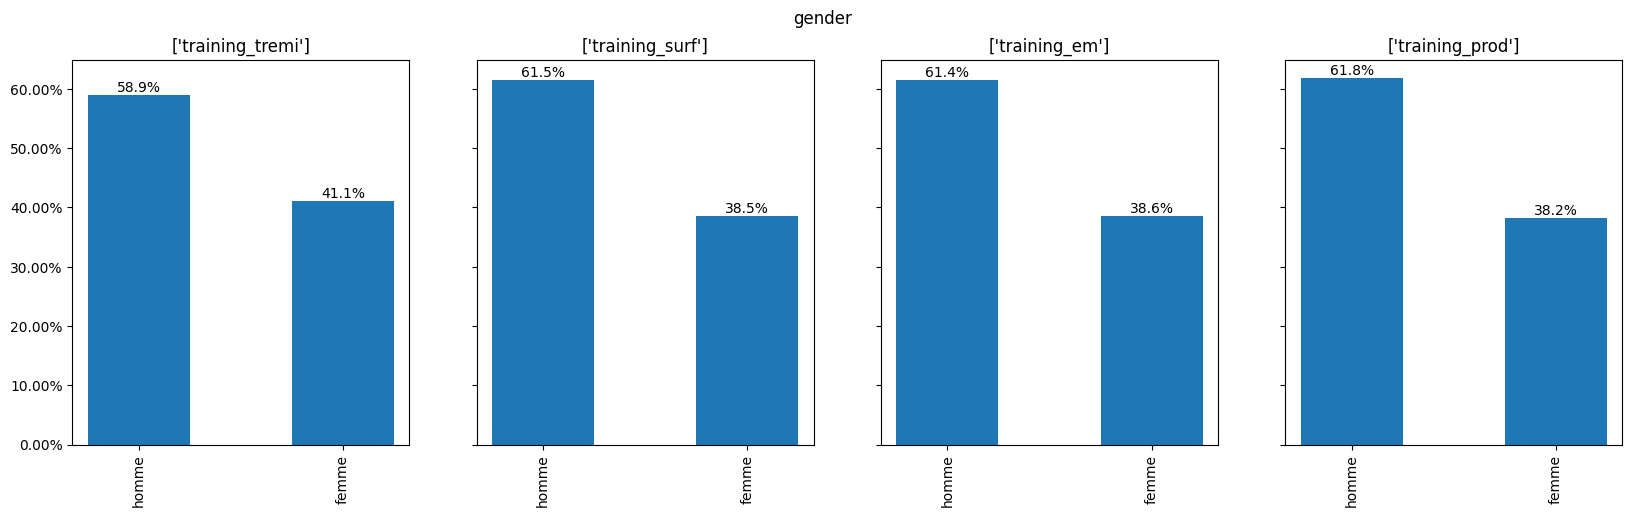

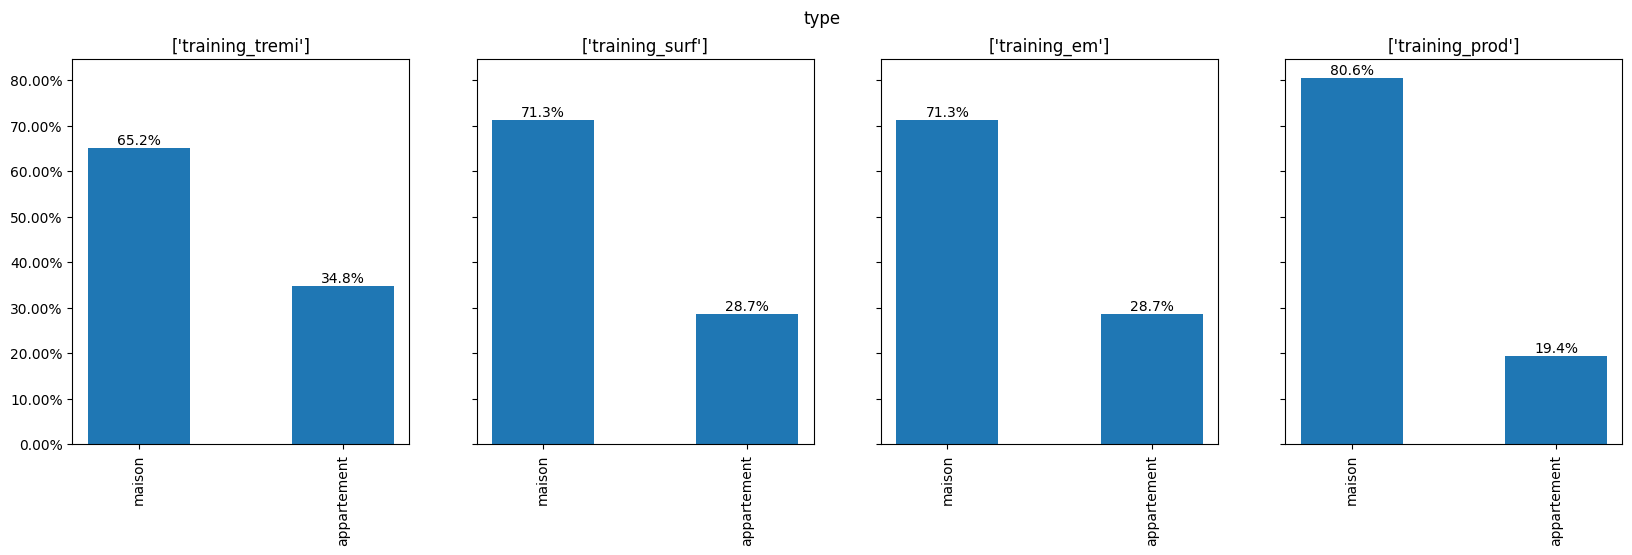

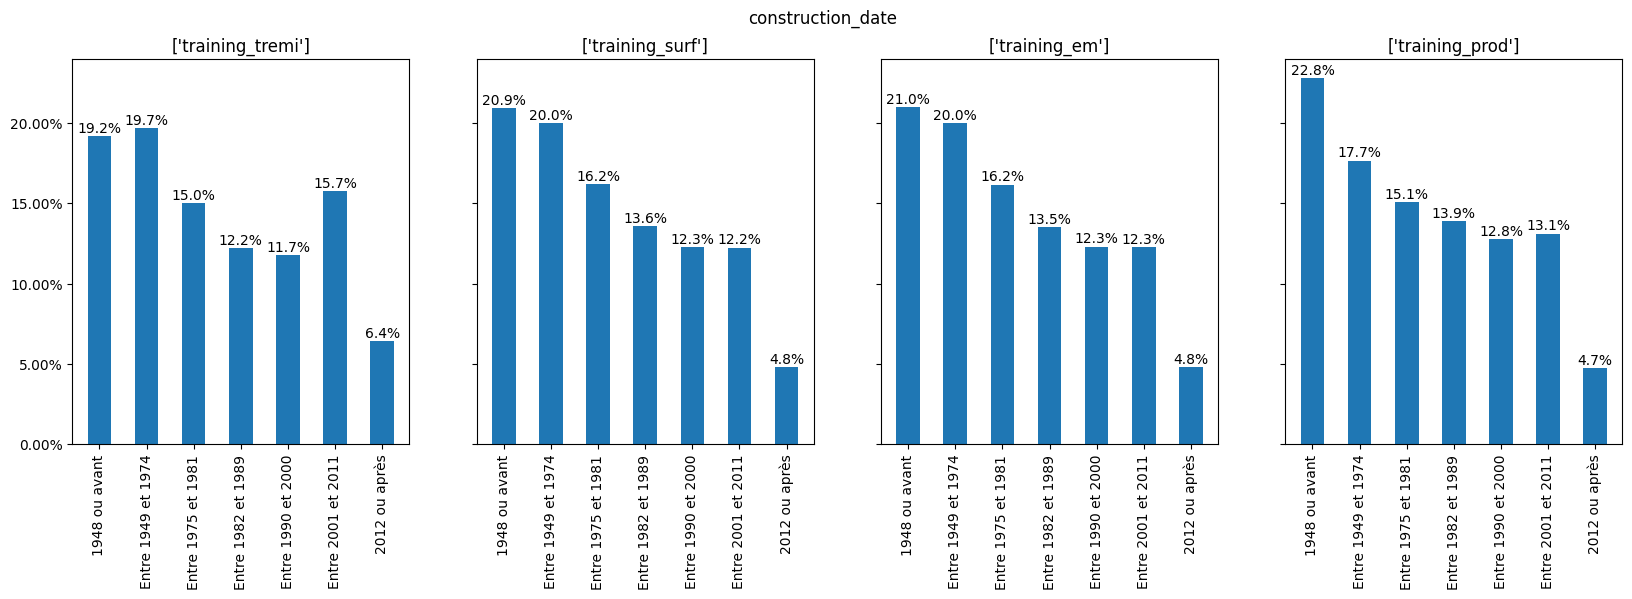

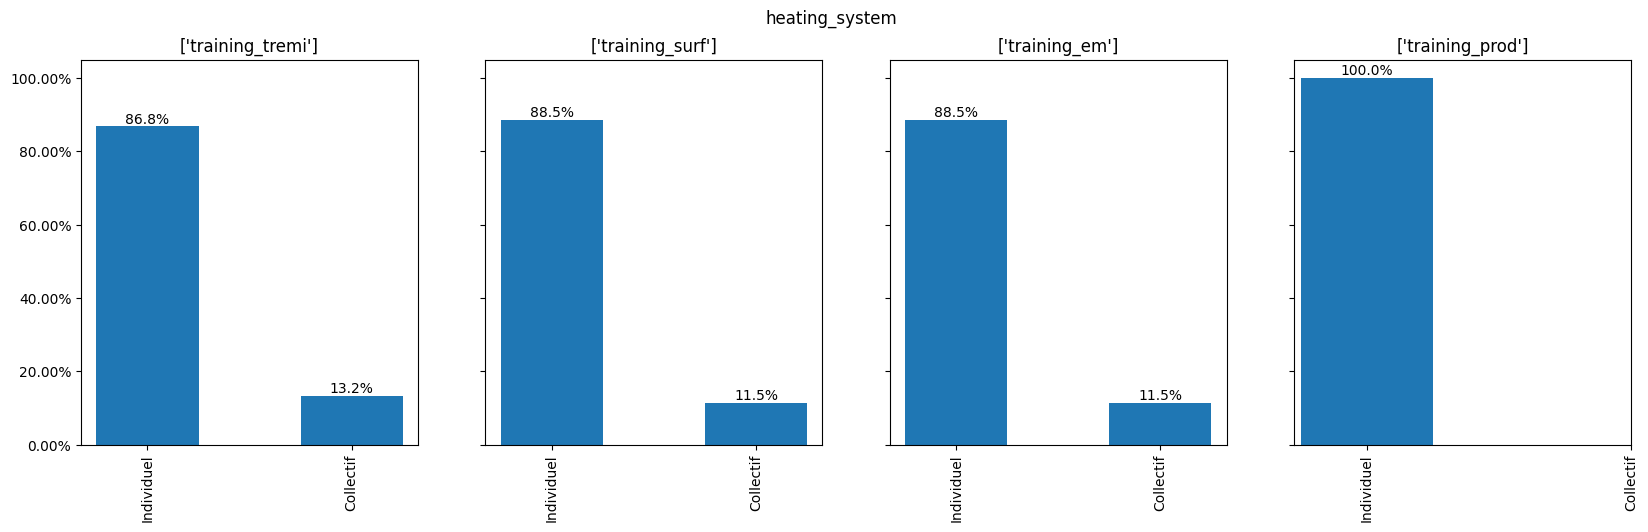

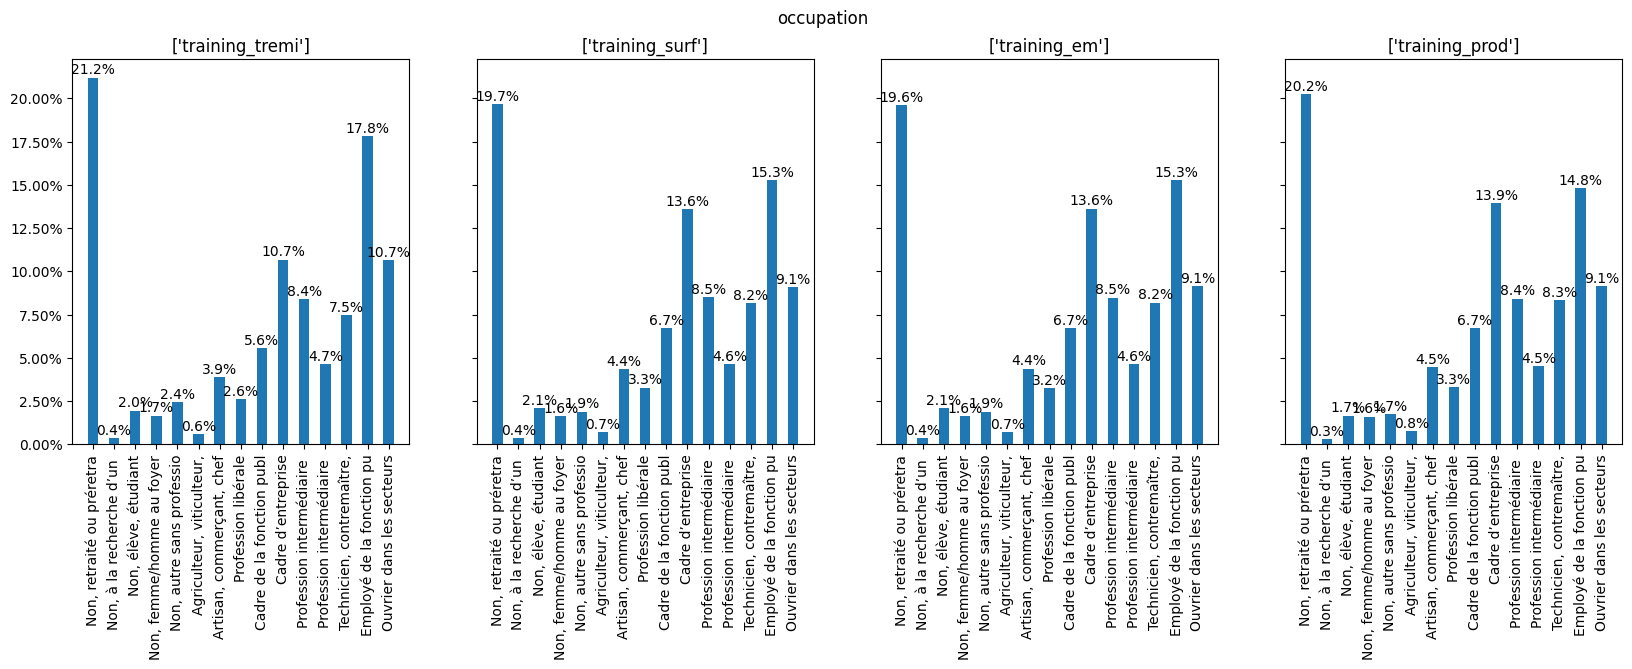

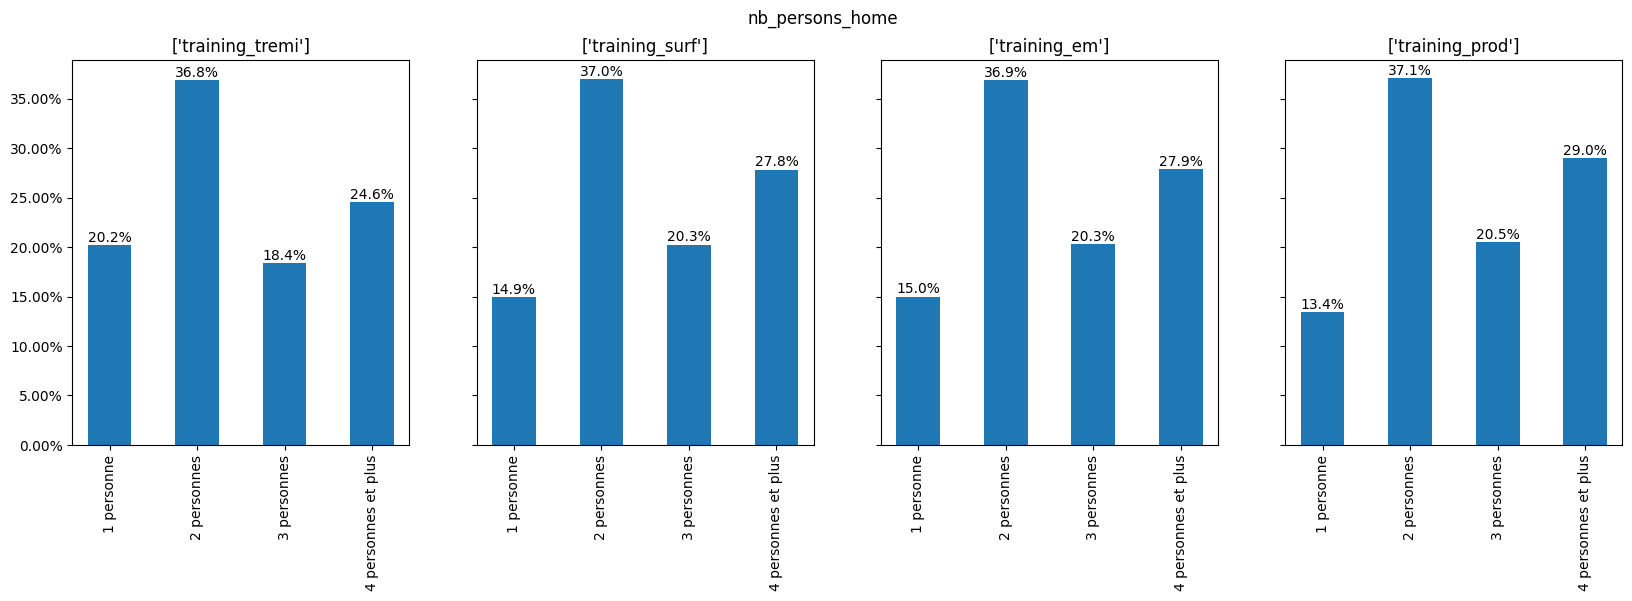

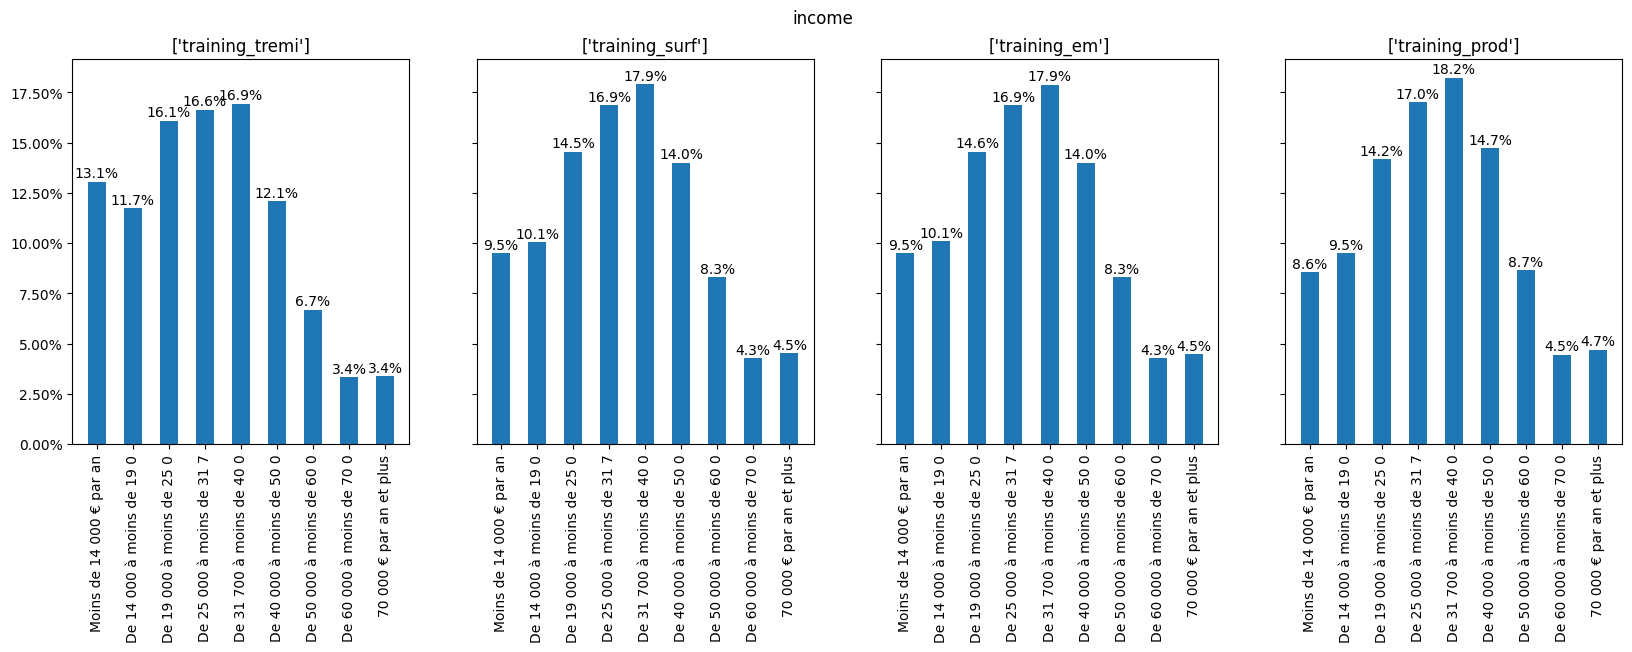

In [6]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, dictionary, 'gender')
compare_repartition(dfs, dictionary, 'type')
compare_repartition(dfs, dictionary, 'construction_date')
compare_repartition(dfs, dictionary, 'heating_system')
compare_repartition(dfs, dictionary, 'occupation')
compare_repartition(dfs, dictionary, 'nb_persons_home')
compare_repartition(dfs, dictionary, 'income')

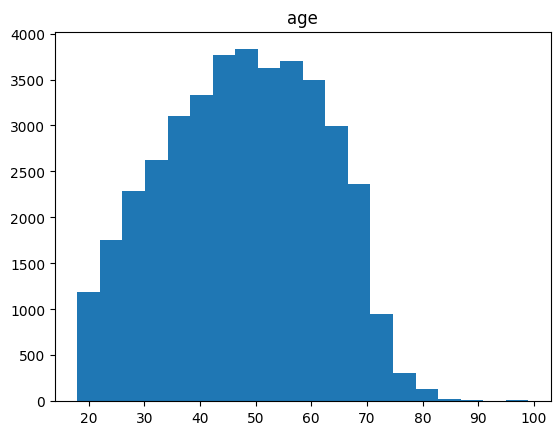

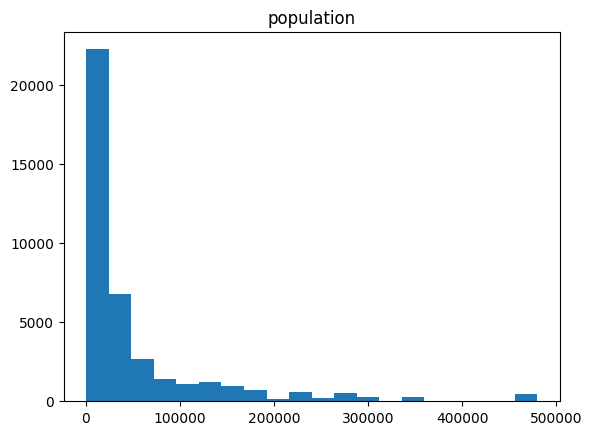

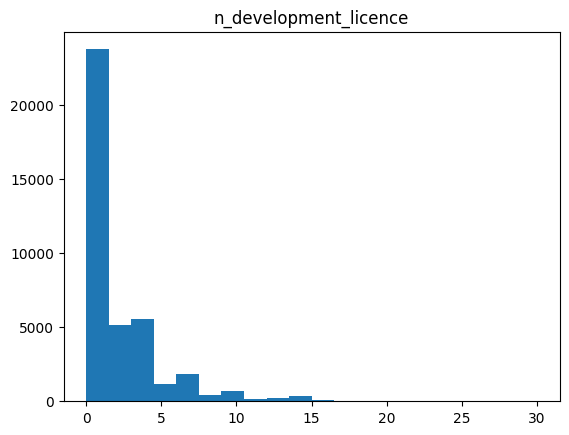

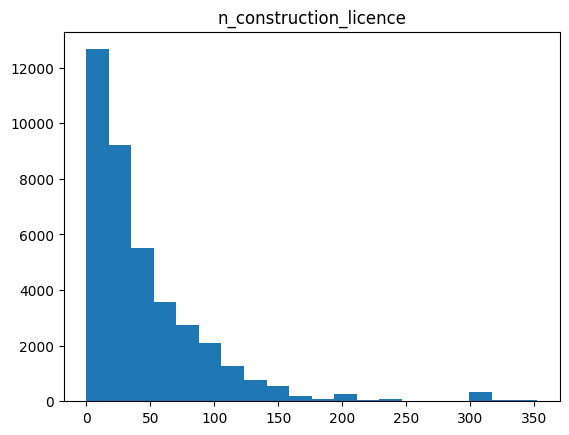

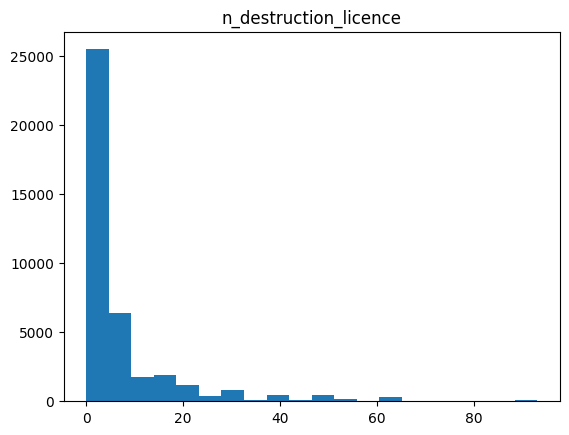

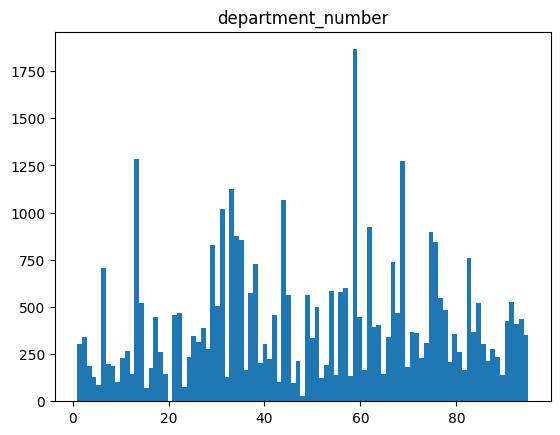

In [7]:
histo_continuous(training_tremi, 'age')
histo_continuous(training_tremi, 'population')
histo_continuous(training_tremi, 'n_development_licence')
histo_continuous(training_tremi, 'n_construction_licence')
histo_continuous(training_tremi, 'n_destruction_licence')
histo_continuous(training_tremi, 'department_number', 95)

# ouput variables

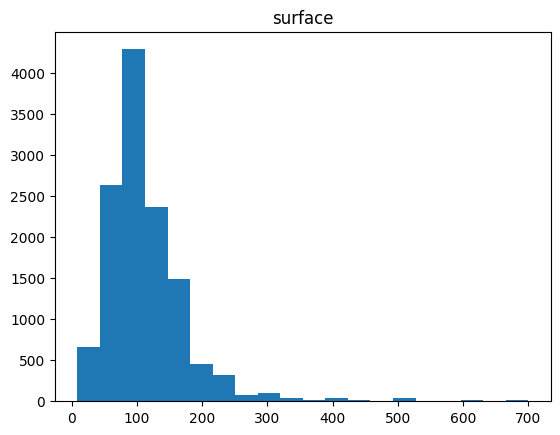

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


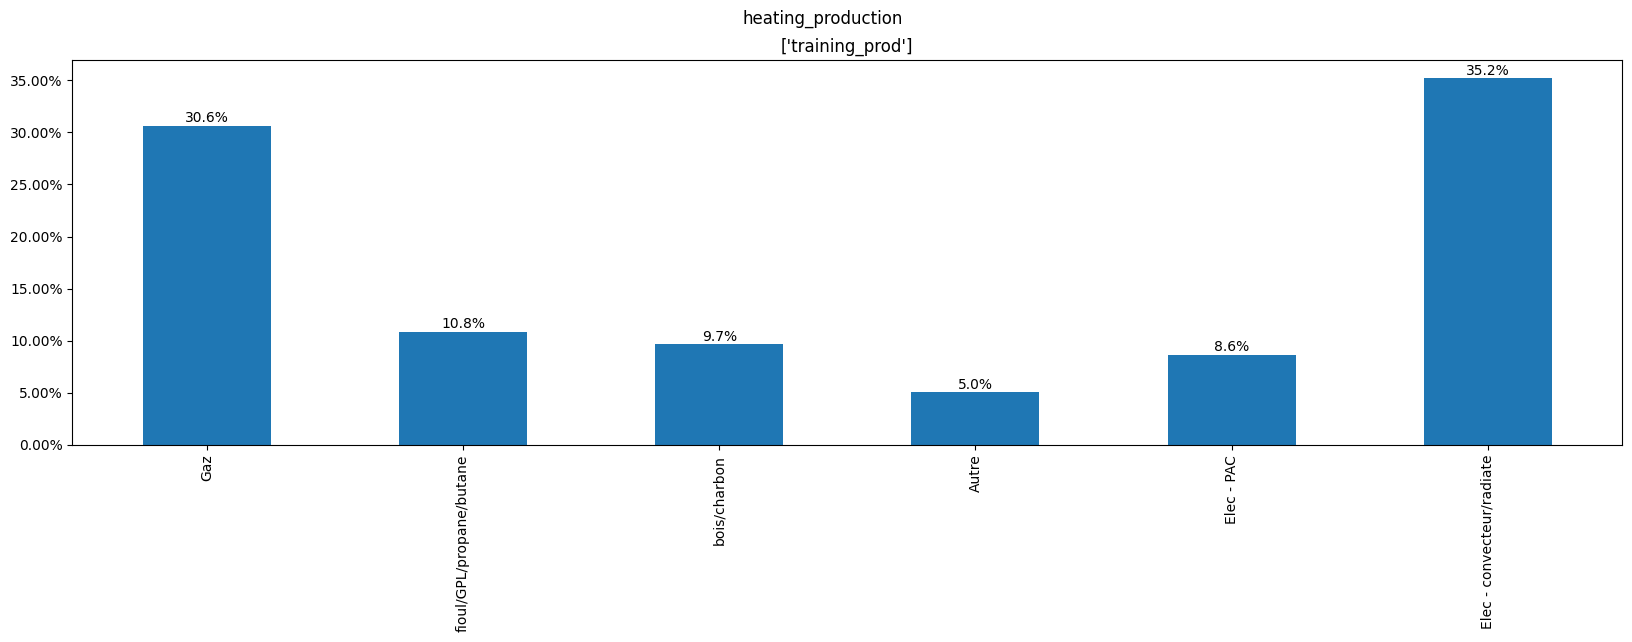

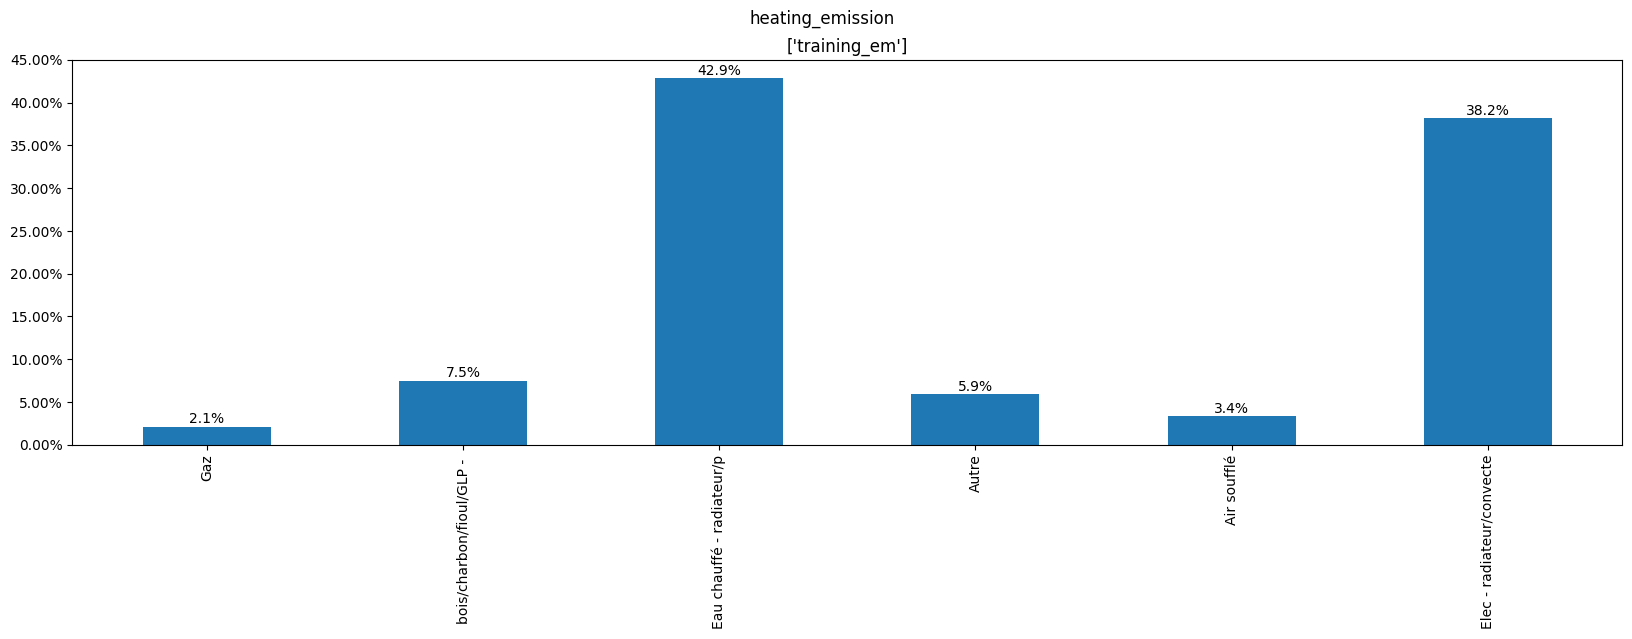

In [8]:
histo_continuous(training_surf, 'surface')
compare_repartition([training_prod], dictionary, 'heating_production')
compare_repartition([training_em], dictionary, 'heating_emission')

# ML

In [21]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

In [22]:
xgb_model = XGBRegressor()
type(xgb_model)

xgboost.sklearn.XGBRegressor

# make cut Surf

In [11]:
col_X_hot = [[]]
col_y = ['surface']
col_X_not_hot = [[col[0]
                  for col in training_surf.dtypes if col[0] not in col_X_hot + col_y]]

hyperparams_models = [
    {
        'n_estimators': [100],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    }
]
models = {
    'RandomForestClassifier': RandomForestClassifier
}
cut_params = {
    'first_value': [30, 40, 50, 60, 70],
    'steps': [25, 35, 45, 55, 65],
    'nb_steps': [1, 2, 3]
}

current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
# register score
best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                         True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
max_score = deepcopy(best_models['RandomForestClassifier'][1])
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * best_models['RandomForestClassifier'][1]
print(score_corrected)
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])
       ] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
    best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                             True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
    score_corrected = coef * best_models['RandomForestClassifier'][1]
    print(score_corrected)
    scores[tuple([param for param in current_params.values()])
           ] = deepcopy(score_corrected)
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

75
1
0.8870374054914445 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.10222285421023569
0 [1, 0, 0]
1
0.841374850775965 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.15869943464695874
1
0.7951651412654197 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.24225166420724437
1
0.7696478312773578 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.33934333348798745
1
0.7225427775567052 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.43191554335283816
1
0.8581874253879824 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.1476642430313424
1
0.8215280541185833 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.2162191225602988
1
0.7805411858336649 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.3069362514289008
1
0.7298050139275767 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.389442309461552
1
0.659769200159172

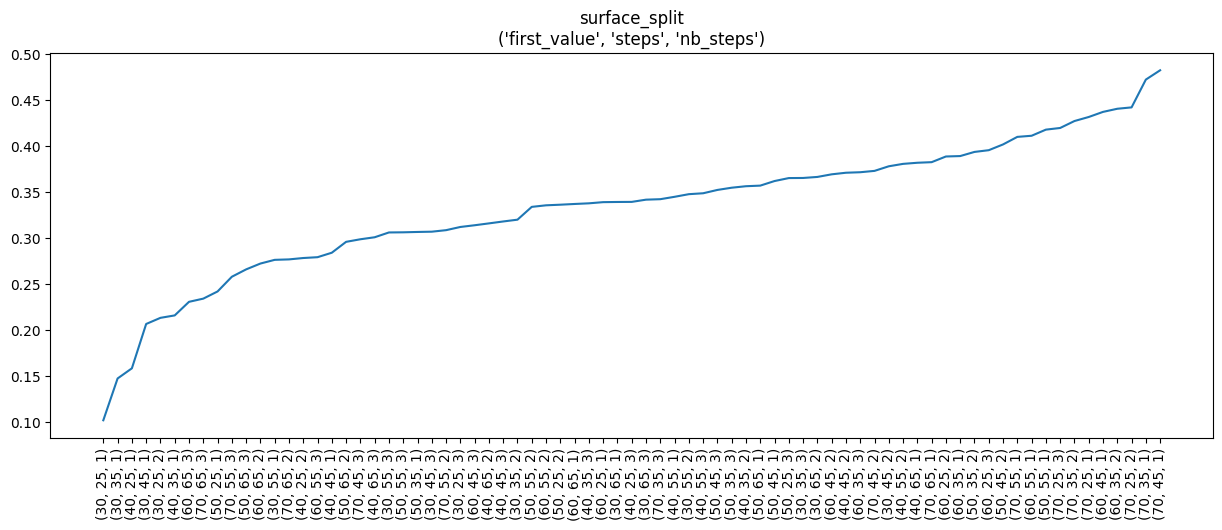

In [12]:
f, ax_hyper = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
show_hyperparam_opti(scores, cut_params, ax_hyper, 'surface_split')
plt.show()

In [13]:
# make the best split
sorted_score = sorted(scores.items(), key=lambda x: x[1]) #sort by score
best_cut = sorted_score[-1][0]
cuts = make_cut(*best_cut)
training_surf, coef = to_categorical(training_surf, 'surface', cuts)

## surface

4
0 {'max_iter': 300, 'C': 1, 'class_weight': 'balanced'}
2 {'max_iter': 300, 'C': 100, 'class_weight': 'balanced'}
0.6120672502984481 {'max_iter': 300, 'C': 1, 'class_weight': 'balanced'}
6
0 {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
2 {'n_estimators': 200, 'max_depth': 35, 'class_weight': 'balanced'}
4 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}
0.6489255869478711 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}
27
0 {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}
7 {'learning_rate': 0.2, 'n_estimators': 200, 'max_depth': 3}
14 {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 5}
21 {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 10}
0.641016713091922 {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 5}


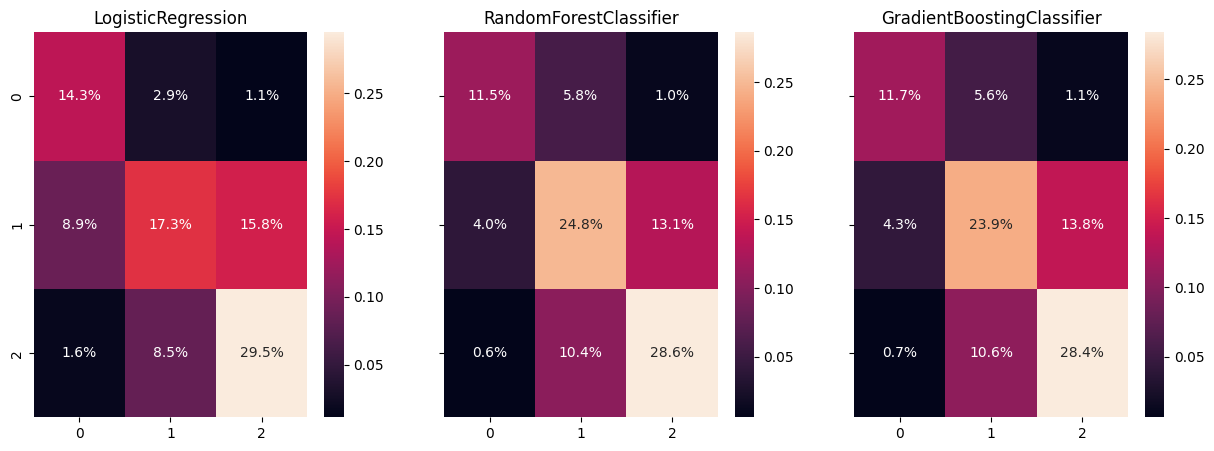

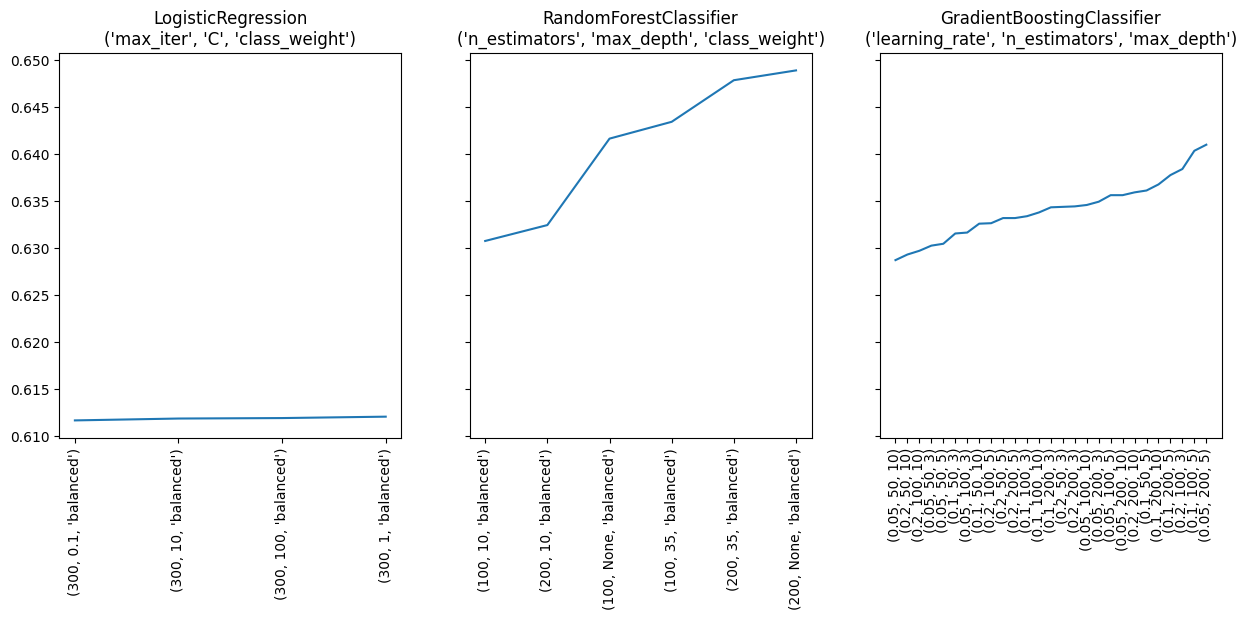

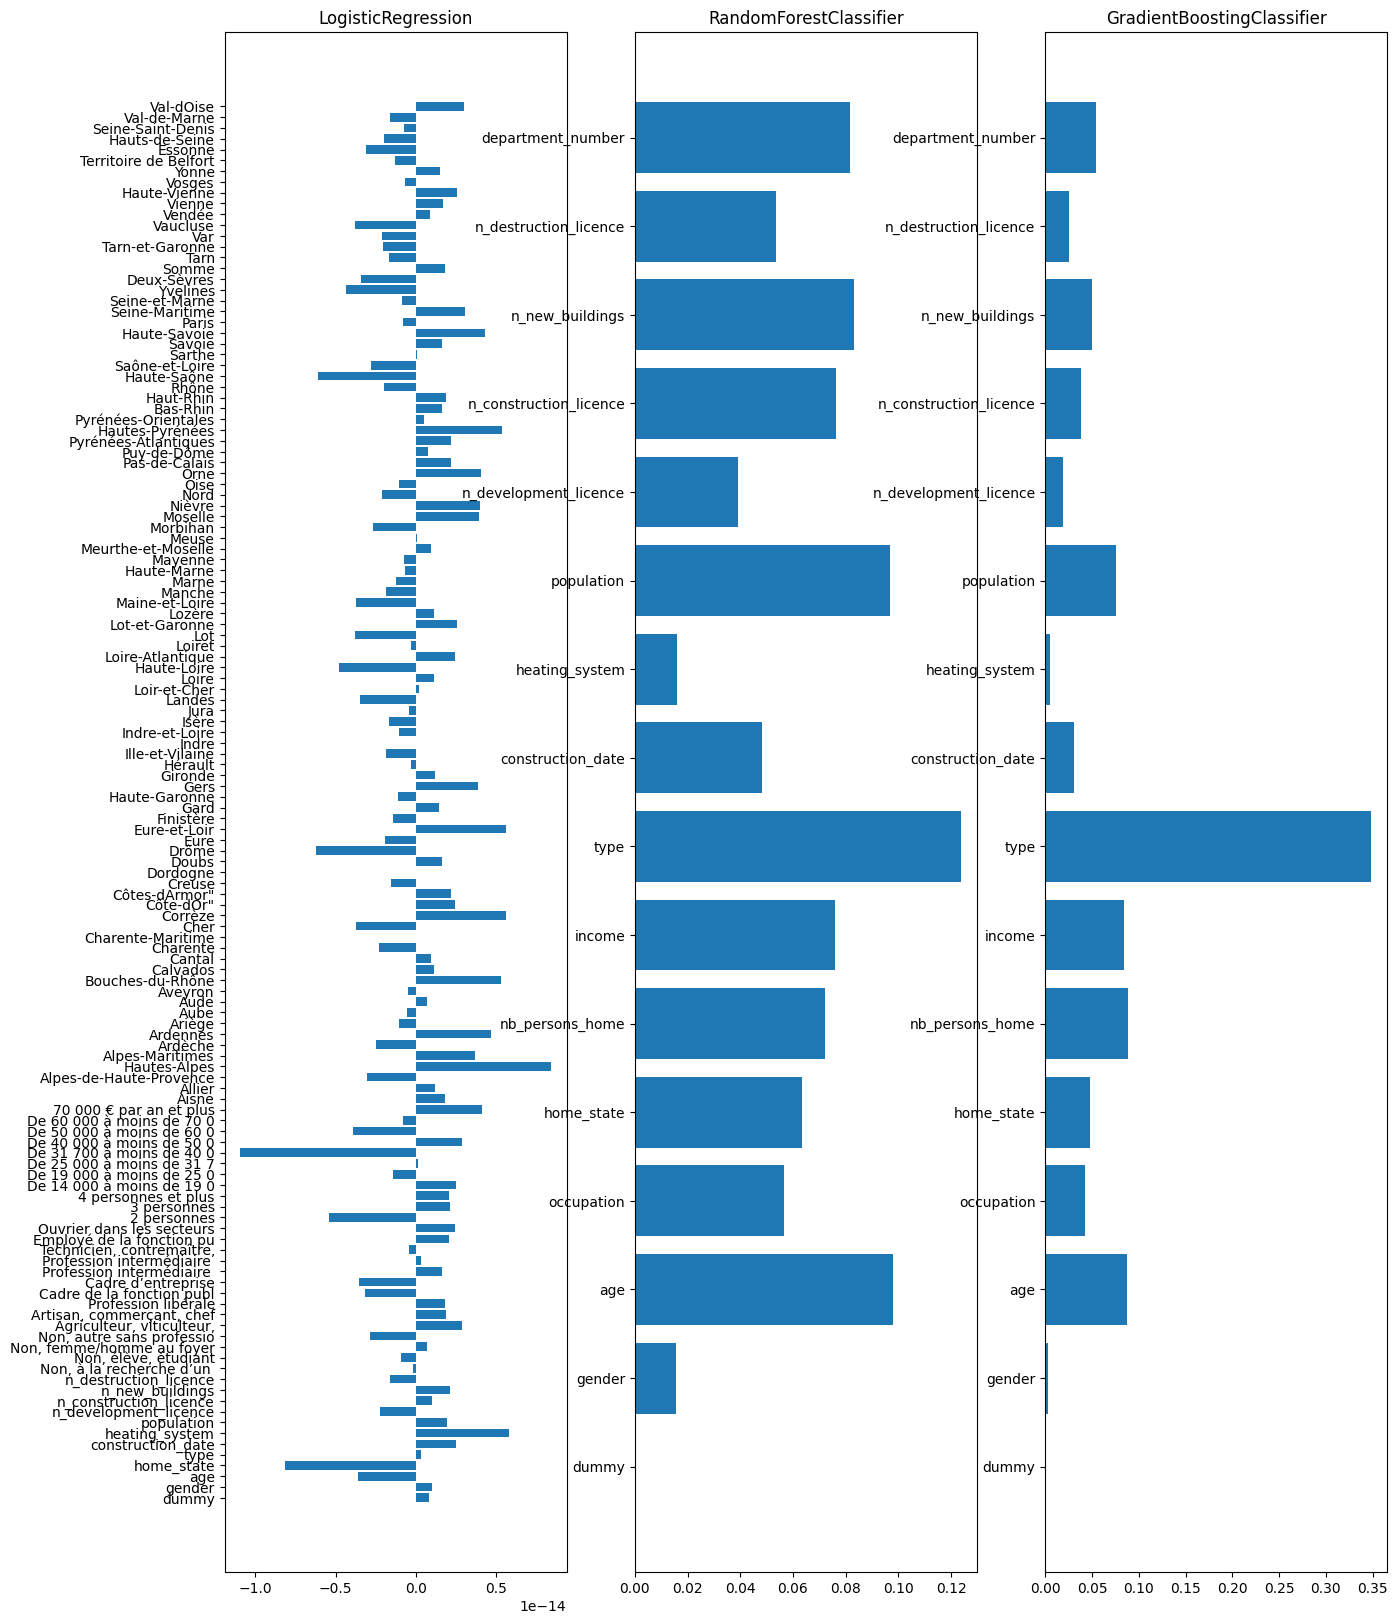

In [14]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [300],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],
    },
    {
        'n_estimators': [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10, 35, None],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}
best_models = all_in_one(training_surf, dictionary, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

## heating_production 

4
0 {'max_iter': 300, 'C': 1, 'class_weight': 'balanced'}


c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 {'max_iter': 300, 'C': 100, 'class_weight': 'balanced'}
0.30519991015274034 {'max_iter': 300, 'C': 0.1, 'class_weight': 'balanced'}
6
0 {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
2 {'n_estimators': 200, 'max_depth': 35, 'class_weight': 'balanced'}
4 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}
0.4599056603773585 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}


KeyboardInterrupt: 

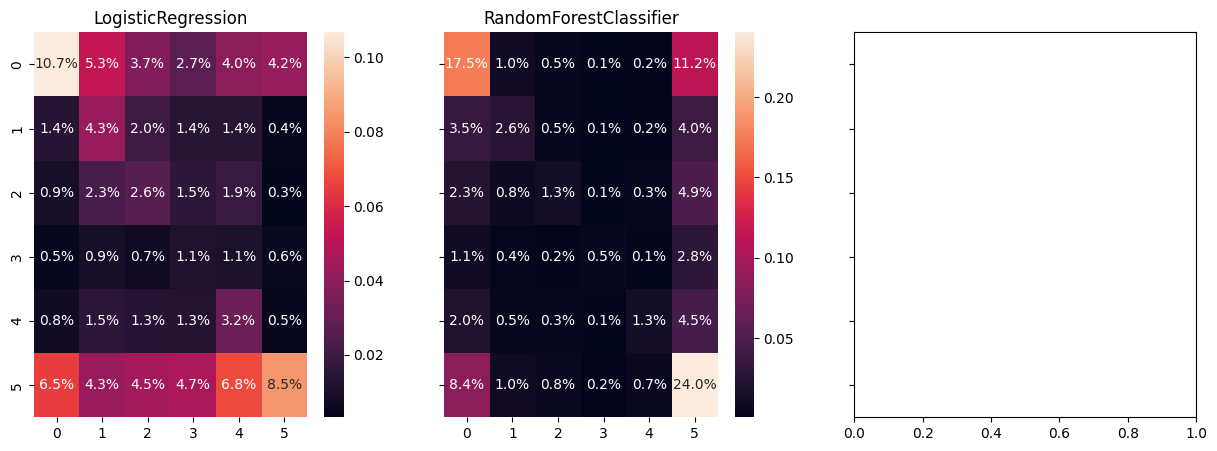

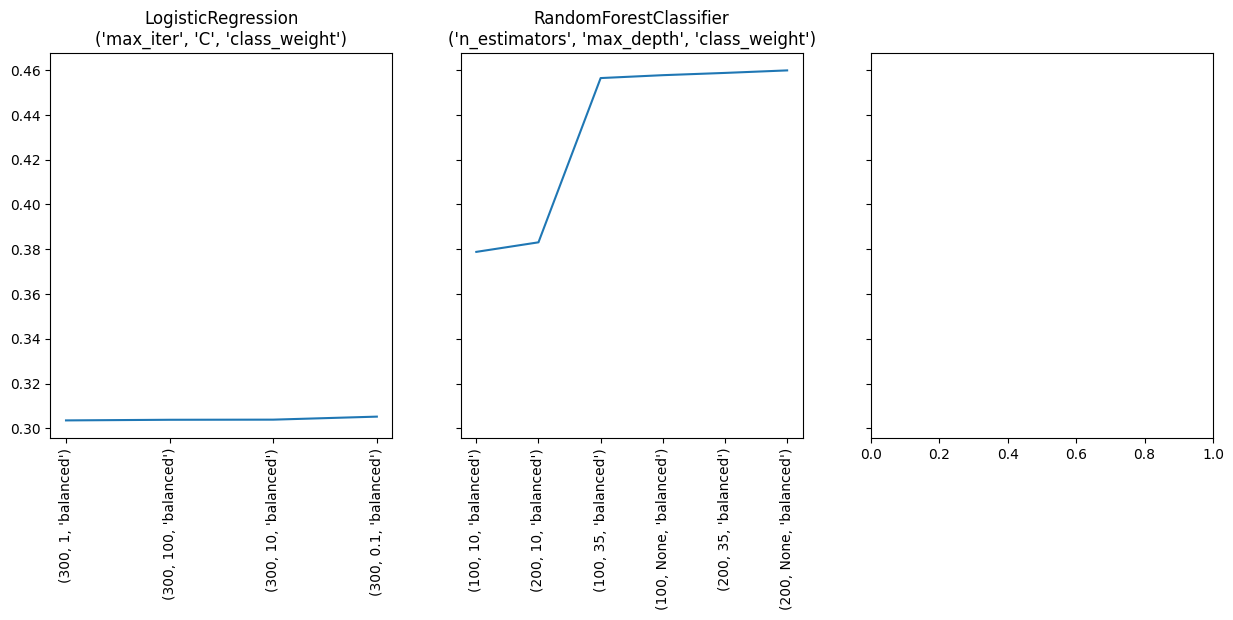

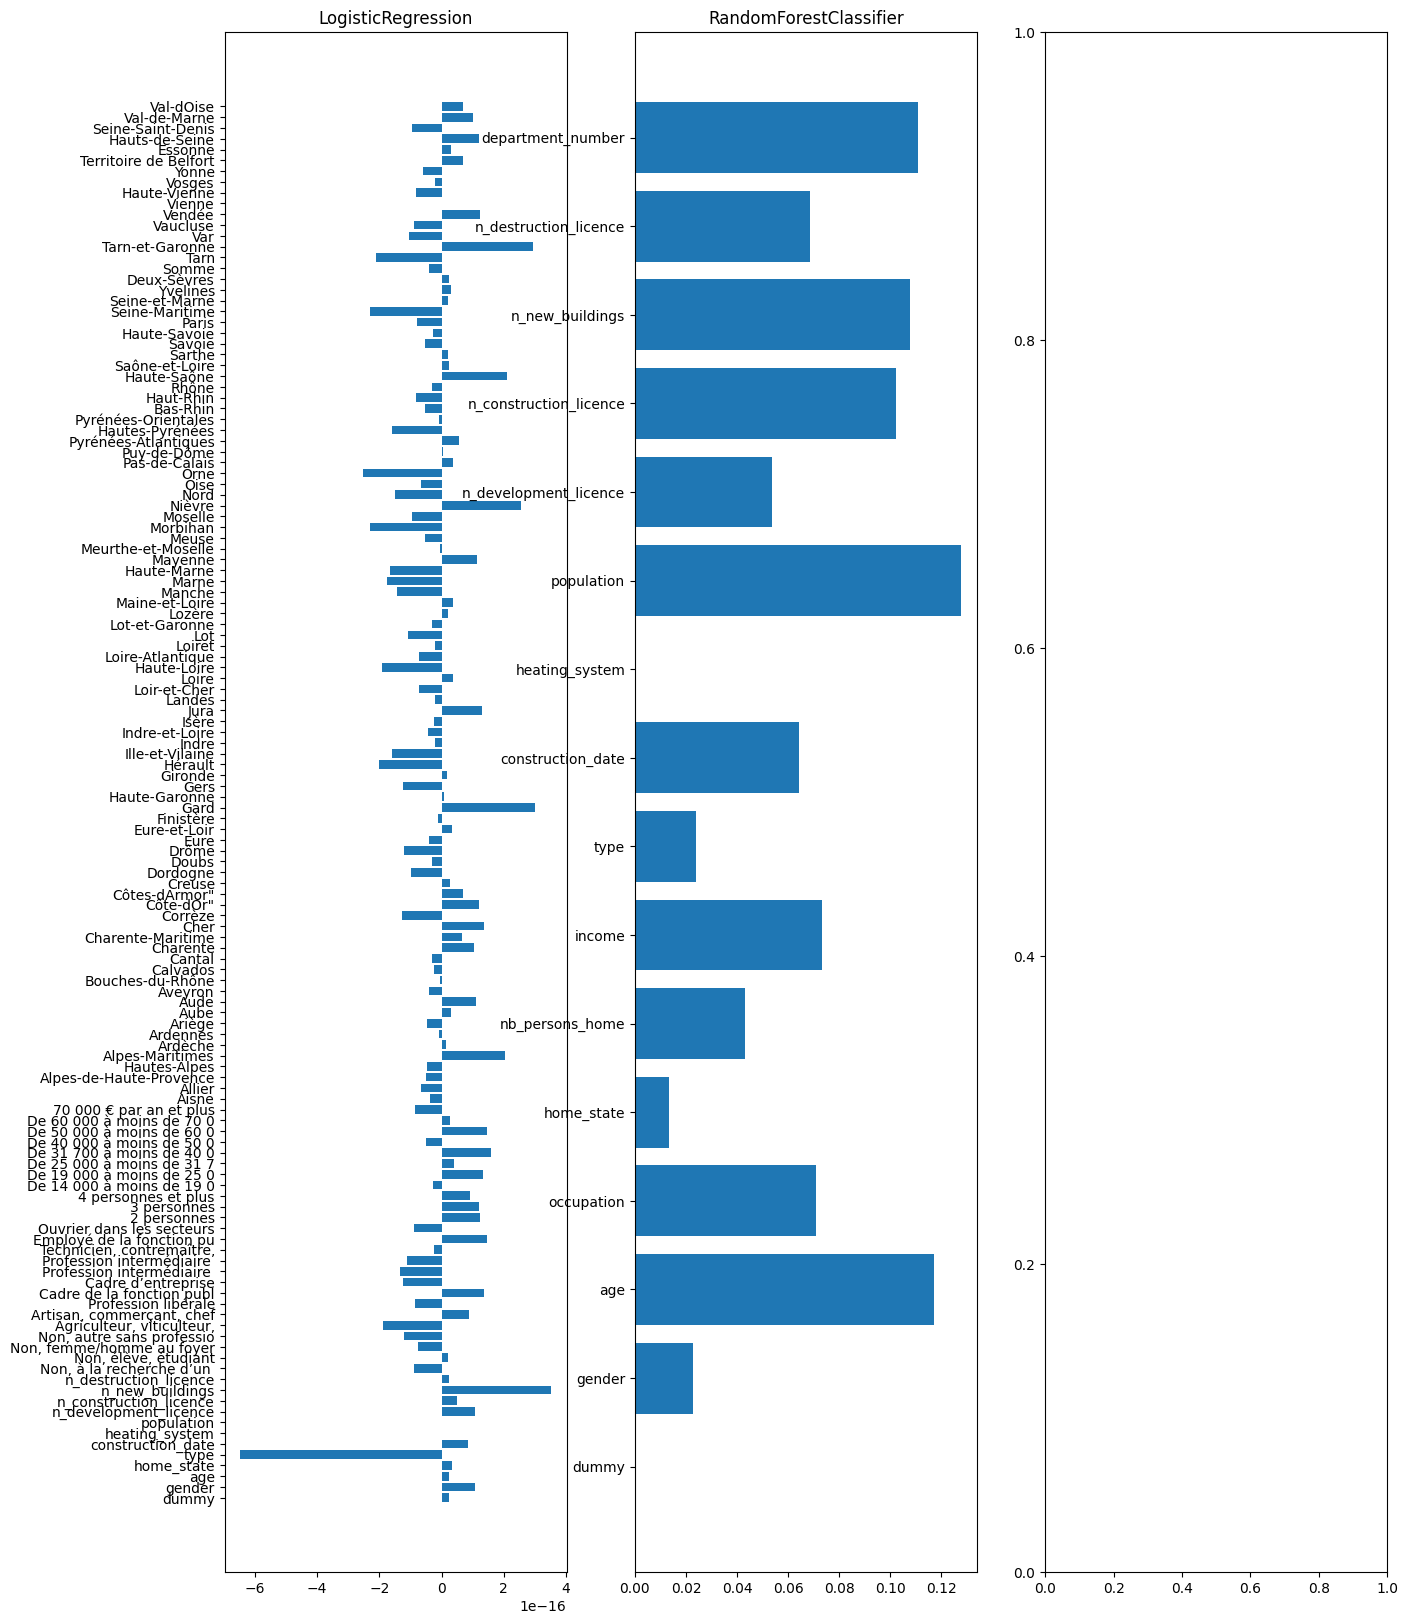

In [15]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['heating_production']
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [300],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],
    },
    {
        'n_estimators': [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10, 35, None],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}
best_models = all_in_one(training_prod, dictionary, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

## heating_emission

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['heating_emission']
col_X_not_hot = [
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [300],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],
    },
    {
        'n_estimators': [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10, 35, None],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}
best_models = all_in_one(training_em, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                         True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)